In [1]:
import os
import json
from docx import Document
from io import StringIO, BytesIO
import re
import time

import pandas as pd
import json
import spacy
from nltk.corpus import stopwords

from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim import matutils, models
from gensim.models import CoherenceModel, TfidfModel
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis.gensim

from docx import Document
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 3})

In [2]:
nlp = spacy.load("en_core_web_sm")
# stop_words = set(stopwords.words('english'))

In [3]:
notebook_dir = os.getcwd()
sop_df = pd.read_csv('../data/interim/sop_types_valid.csv', 
                     converters = {'juri': eval, 
                                   'filename': eval})

In [4]:
sop_df.head(3)

,type,juri,filename,juri_count
0,1033,"[AB, BI, BU, DE, DFPF, NW, PO, RI, RM, SC, SQ,...","[AB - 1033 - Officer in trouble.docx, BI - 103...",16
1,DOMI,"[AB, BI, BU, DE, DFPF, NW, PO, RI, RM, SC, SQ,...","[AB - DOMI - Domestic in progress.docx, BI - D...",16
2,FOUNDP,"[AB, BI, BU, DE, DFPF, NW, PO, RI, RM, SC, SQ,...","[AB - FOUNDP - Found Person.docx, BI - FOUNDP ...",16


In [5]:
type_list = sop_df['type']
type_list

0       1033
1       DOMI
2     FOUNDP
3     HAZARD
4     IMPAIR
       ...  
92    INDUST
93    ASSMHA
94      SPAT
95    ALARMD
96       DNA
Name: type, Length: 97, dtype: object

In [6]:
def load_event_role(event_type, role):
    with open(F'../data/sop_jsons/{event_type}.txt') as f:
        dct = json.load(f)
    f.close()
    event_row = sop_df[sop_df['type'] == event_type]
    juri_to_filename = dict(zip(event_row['juri'].values[0], 
                                event_row['filename'].values[0]))
    types, juris, roles, sops = list(), list(), list(), list()
    for juri, role_sop in dct.items():
        if role in role_sop:
            types.append(event_type)
            juris.append(juri)
            roles.append(role)
            sops.append(role_sop[role])
    df = pd.DataFrame({'type': types, 'juri': juris, 'role': roles, 'sop': sops})
    df['filename'] = df['juri'].apply(lambda x: juri_to_filename[x])
    return df

In [7]:
def load_event_types_for_role(types, role):
    res = pd.DataFrame()
    for t in types:
        res = res.append(load_event_role(t, role))
    return res.reset_index(drop = True)

In [8]:
calltaker_all = load_event_types_for_role(type_list, 'call taker')

In [9]:
calltaker_all

,type,juri,role,sop,filename
0,1033,AB,call taker,"[Create a call, Questions, Are there weapons i...",AB - 1033 - Officer in trouble.docx
1,1033,BI,call taker,"[Create a call, Questions, Are there weapons i...",BI - 1033 - Officer in trouble.docx
2,1033,BU,call taker,"[Create a call, Questions, Are there weapons i...",BU - 1033 - Officer in trouble.docx
3,1033,DE,call taker,"[Create a call, Questions, Are there weapons i...",DE - 1033 - Officer in trouble.docx
4,1033,DFPF,call taker,"[Create a call, Questions, Are there weapons i...",DFPF - 1033 - Officer in trouble.docx
...,...,...,...,...,...
1463,DNA,SX,call taker,"[This file type is not used., DNA Warrant:, Se...",SX - DNA - DNA collection.docx
1464,DNA,UN,call taker,"[This file type is not used., DNA Warrant:, Se...",UN - DNA - DNA collection.docx
1465,DNA,VA,call taker,"[This file type is not used., DNA Warrant:, Se...",VA - DNA - DNA collection.docx
1466,DNA,WP,call taker,"[This file type is not used., DNA Warrant:, Se...",WP - DNA - DNA collection.docx


In [10]:
def preprocess(strlist,
               min_token_len = 2,
               allowed_pos = ['ADV', 'ADJ', 'VERB', 'NOUN', 'PART', 'NUM']): 
    removal = ['-', r'i\.e\.']
    res = list()
    for string in strlist:
        text = re.sub(r"|".join(removal), ' ', string.lower())
        doc = nlp(text)
        res += [token.lemma_ for token in doc \
               if token.pos_ in allowed_pos \
               # Spacy considers 'call' as a stop word, which is not suitable for our case
#                and not token.is_stop \
#                and token.text not in stop_words \              
#                and token.is_alpha \
               and len(token.lemma_) > min_token_len
               ]
    
    return ' '.join(res)

In [11]:
preprocess(calltaker_all.iloc[0, :]['sop'])

'create call question weapon involve exact location backyard alley member uniform plain clothe other member scene can see police vehicle where type vehicle marked unmarked vehicle identification number visible'

In [12]:
def get_dct_dtmatrix(sops):
    corpus = [sop.split() for sop in map(preprocess, sops)]
#     phrases = Phrases(corpus, min_count = 1, threshold = 1)
#     bigram = Phraser(phrases)
#     corpus = bigram(corpus)
    dictionary = corpora.Dictionary(corpus)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    return doc_term_matrix, corpus, dictionary

In [13]:
def tfidf_dct_dtmatrix(sops):
    doc_term_matrix, corpus, dictionary = get_dct_dtmatrix(sops)
    tfidf = TfidfModel(doc_term_matrix)
    return doc_term_matrix, corpus, dictionary, tfidf[doc_term_matrix]

In [15]:
doc_term_bow, corpus, dictionary, doc_term_tfidf = tfidf_dct_dtmatrix(calltaker_all['sop'])

In [24]:
def topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                          passes, coherence, alpha,
                          N = 100, random_state = 2020):
    num_topic, ldas, scores = list(), list(), list()
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
    for n in range(1, N+1):
        lda = models.LdaModel(corpus = doc_term_matrix, 
                              id2word = dictionary, 
                              num_topics = n, 
                              passes = passes, 
                              random_state = random_state, 
                              alpha = alpha)
        coherence_model = CoherenceModel(
            model = lda, 
            texts = corpus, 
            dictionary = dictionary, 
            coherence = coherence)
        coherence_score = coherence_model.get_coherence()
#         mod = {'num_topic': n, 'model': lda, 'coherence_score': coherence_score}
#         res[f"num_topic={n}"] = [lda, coherence_score]
        num_topic.append(n)
        ldas.append(lda)
        scores.append(coherence_score)
    return pd.DataFrame({
        'num_topic':num_topic,
        'model': ldas,
        'coherence_score': scores
    })

In [25]:
def save_df(df, name):
    filename = '../data/interim/' + name
    df.to_csv(filename, index = False)

In [26]:
def tune_coherence(doc_term_matrix, corpus, dictionary, 
                   num_pass, coherence, alpha, mdtype):
    coh = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                passes = num_pass, coherence = coherence, alpha = alpha)
    name = f'call_{coherence}_{mdtype}_{num_pass}_{alpha}.csv'
    save_df(coh, name)
    return coh

In [27]:
import datetime
t0 = time.time()
num_pass, coherence, alpha = 20, 'c_npmi', 'asymmetric'

call_coh_20_bow = tune_coherence(doc_term_bow, corpus, dictionary, 
                                  num_pass, coherence, alpha, 'bow')

call_coh_20_tfidf = tune_coherence(doc_term_tfidf, corpus, dictionary, 
                                  num_pass, coherence, alpha, 'tfidf')

ellapsed = str(datetime.timedelta(seconds = time.time() - t0))
print(f'It takes {ellapsed} to run 20 passes')

It takes 2:41:31.746779 to run 20 passes


In [55]:
def plot_coh(df, md_type, N = 40):
    fig, ax = plt.subplots(1, 1, figsize = (12, 3))
    ax.plot(df.loc[:N, 'num_topic'].values, 
            df.loc[:N, 'coherence_score'].values)
    ax.set_xlabel('number of topics')
    ax.set_ylabel('coherence score')
    ax.set_title(f'Coherence Score vs Number of Topics ({md_type})')
    ax.grid()
    plt.show()

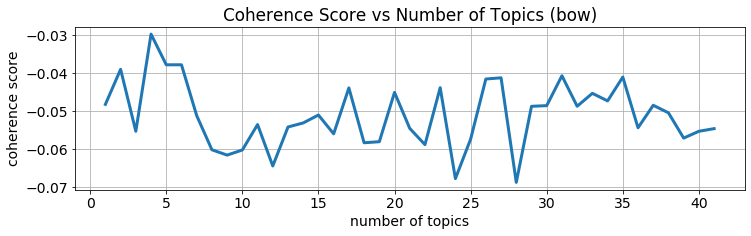

In [70]:
plot_coh(call_coh_20_bow, 'bow', N = 40)

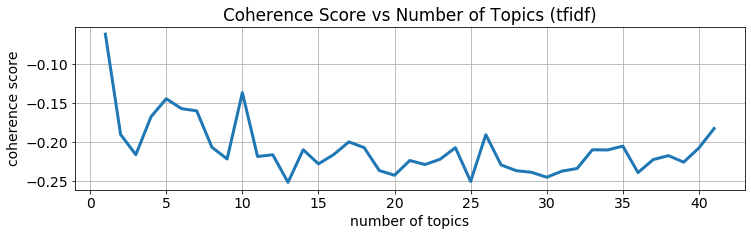

In [71]:
plot_coh(call_coh_20_tfidf, 'tfidf', N = 40)

In [58]:
lda_event_bow = call_coh_20_bow[call_coh_20_bow['num_topic'] == 64]['model'].values[0]
fpath = '../data/interim/lda_event_bow'
lda_event_bow.save(fpath)

In [72]:
lda_event_bow_26 = call_coh_20_bow[call_coh_20_bow['num_topic'] == 26]['model'].values[0]
fpath = '../data/interim/lda_event_bow_26'
lda_event_bow_26.save(fpath)

In [59]:
lda_event_tfidf = call_coh_20_tfidf[call_coh_20_tfidf['num_topic'] == 10]['model'].values[0]
fpath = '../data/interim/lda_event_tfidf'
lda_event_tfidf.save(fpath)

In [81]:
lda_event_tfidf_26 = call_coh_20_tfidf[call_coh_20_tfidf['num_topic'] == 26]['model'].values[0]
fpath = '../data/interim/lda_event_tfidf_26'
lda_event_tfidf_26.save(fpath)

In [60]:
print(lda_event_bow)

LdaModel(num_terms=1818, num_topics=64, decay=0.5, chunksize=2000)


In [82]:
print(lda_event_tfidf_26)

LdaModel(num_terms=1818, num_topics=26, decay=0.5, chunksize=2000)


In [62]:
def get_topic(model, doc):
    ppdoc = preprocess(doc)
    doc_term_arr = dictionary.doc2bow(ppdoc.split())
    return sorted(model[doc_term_arr], 
                  key = lambda x: x[1], 
                  reverse = True)[0][0]

In [63]:
event_topics_bow = calltaker_all.copy()
event_topics_bow['topic_id'] = list(map(lambda x: get_topic(lda_event_bow, x), 
                                                        event_topics_bow['sop'].values.tolist()))

In [99]:
event_topics_bow[event_topics_bow['topic_id'] == 2].head(40)

,type,juri,role,sop,filename,topic_id
0,1033,AB,call taker,"[Create a call, Questions, Are there weapons i...",AB - 1033 - Officer in trouble.docx,2
1,1033,BI,call taker,"[Create a call, Questions, Are there weapons i...",BI - 1033 - Officer in trouble.docx,2
2,1033,BU,call taker,"[Create a call, Questions, Are there weapons i...",BU - 1033 - Officer in trouble.docx,2
3,1033,DE,call taker,"[Create a call, Questions, Are there weapons i...",DE - 1033 - Officer in trouble.docx,2
4,1033,DFPF,call taker,"[Create a call, Questions, Are there weapons i...",DFPF - 1033 - Officer in trouble.docx,2
5,1033,NW,call taker,"[Create a call, Questions, Are there weapons i...",NW - 1033 - Officer in trouble.docx,2
6,1033,PO,call taker,"[Create a call, Questions, Are there weapons i...",PO - 1033 - Officer in trouble.docx,2
7,1033,RI,call taker,"[Create a call, Questions, Are there weapons i...",RI - 1033 - Officer in trouble.docx,2
8,1033,RM,call taker,"[Create a call, Questions, Are there weapons i...",RM - 1033 - Officer in trouble.docx,2
9,1033,SC,call taker,"[Create a call, Questions, Are there weapons i...",SC - 1033 - Officer in trouble.docx,2


In [73]:
event_topics_bow_26 = calltaker_all.copy()
event_topics_bow_26['topic_id'] = list(map(lambda x: get_topic(lda_event_bow_26, x), 
                                                        event_topics_bow_26['sop'].values.tolist()))

In [96]:
event_topics_bow_26 = event_topics_bow_26.sort_values(by = ['topic_id', 'type', 'juri'], ignore_index = True)
event_bow_26_topic1 = event_topics_bow_26[event_topics_bow_26['topic_id'] == 1]
event_bow_26_topic1.head(40)

,type,juri,role,sop,filename,topic_id
151,911,AB,call taker,"[Create a call, Clearly describe the event in ...",AB - 911.docx,1
152,911,BI,call taker,"[Create a call, Clearly describe the event in ...",BI - 911.docx,1
153,911,BU,call taker,"[Create a call, Clearly describe the event in ...",BU - 911.docx,1
154,911,DE,call taker,"[Create a call, Clearly describe the event in ...",DE - 911.docx,1
155,911,DFPF,call taker,"[Create a call, Clearly describe the event in ...",DFPF - 911.docx,1
156,911,NW,call taker,"[Create a call, Clearly describe the event in ...",NW - 911.docx,1
157,911,PO,call taker,"[Create a call, Clearly describe the event in ...",PO - 911.docx,1
158,911,RI,call taker,"[Create a call, Clearly describe the event in ...",RI - 911.docx,1
159,911,RM,call taker,"[Create a call, Clearly describe the event in ...",RM - 911.docx,1
160,911,SC,call taker,"[Create a call, Clearly describe the event in ...",SC - 911.docx,1


In [100]:
event_bow_26_topic1.iloc[1, :]['sop']

['Create a call',
 'Clearly describe the event in remarks',
 'Update to the appropriate event type upon further investigation']

In [101]:
event_bow_26_topic1.iloc[20, :]['sop']

['Create a call.',
 'Questions:',
 'How long have you been away from the premises?',
 'Was there an unsuccessful attempt to gain entry or did the suspect gain access? (Attempt only?)',
 'Where is the door or window where the attempt was made or entry was gained?',
 'Any tools or weapons left at the scene?',
 'Did the suspect obtain any property?',
 'Where any vehicles stolen?',
 'If a vehicle(s) was stolen during the BNE',
 'Forward the file to ER1 and include the following information',
 'Licence plate',
 'Vehicle description',
 'Request to add vehicle to CPIC',
 'Include special circumstances (is the victim elderly, did the suspect leave personal property behind, etc.)',
 'Advise the caller:',
 'To try not to touch any evidence (fingerprints) that may be found on flat surfaces, windows or walls near the point of entry and exit.',
 'Not to fix any damage until a member arrives or contacts them.',
 'To try to compile a list of property stolen including any serial numbers.',
 'BNE Cance

In [64]:
event_topics_tfidf = calltaker_all.copy()
event_topics_tfidf['topic_id'] = list(map(lambda x: get_topic(lda_event_tfidf, x), 
                                                        event_topics_tfidf['sop'].values.tolist()))

In [90]:
event_topics_tfidf[event_topics_tfidf['topic_id'] == 2].head(40)

,type,juri,role,sop,filename,topic_id
0,1033,AB,call taker,"[Create a call, Questions, Are there weapons i...",AB - 1033 - Officer in trouble.docx,2
1,1033,BI,call taker,"[Create a call, Questions, Are there weapons i...",BI - 1033 - Officer in trouble.docx,2
2,1033,BU,call taker,"[Create a call, Questions, Are there weapons i...",BU - 1033 - Officer in trouble.docx,2
3,1033,DE,call taker,"[Create a call, Questions, Are there weapons i...",DE - 1033 - Officer in trouble.docx,2
4,1033,DFPF,call taker,"[Create a call, Questions, Are there weapons i...",DFPF - 1033 - Officer in trouble.docx,2
5,1033,NW,call taker,"[Create a call, Questions, Are there weapons i...",NW - 1033 - Officer in trouble.docx,2
6,1033,PO,call taker,"[Create a call, Questions, Are there weapons i...",PO - 1033 - Officer in trouble.docx,2
7,1033,RI,call taker,"[Create a call, Questions, Are there weapons i...",RI - 1033 - Officer in trouble.docx,2
8,1033,RM,call taker,"[Create a call, Questions, Are there weapons i...",RM - 1033 - Officer in trouble.docx,2
9,1033,SC,call taker,"[Create a call, Questions, Are there weapons i...",SC - 1033 - Officer in trouble.docx,2


In [85]:
event_topics_tfidf_26 = calltaker_all.copy()
event_topics_tfidf_26['topic_id'] = list(map(lambda x: get_topic(lda_event_tfidf_26, x), 
                                                        event_topics_tfidf_26['sop'].values.tolist()))

In [92]:
event_topics_tfidf_26 = event_topics_tfidf_26.sort_values(by = ['topic_id', 'type', 'juri'], ignore_index = True)
event_tfidf_26_topic0 = event_topics_tfidf_26[event_topics_tfidf_26['topic_id'] == 0]
event_tfidf_26_topic0.head(30)

,type,juri,role,sop,filename,topic_id
0,AB911 LANDLINE,AB,call taker,"[Emergency, Create a call, Make at least 2 cal...",AB - AB911 Landline.docx,0
1,AB911 LANDLINE,BI,call taker,"[Emergency, Create a call, Make at least 2 cal...",BI - AB911 Landline.docx,0
2,AB911 LANDLINE,BU,call taker,"[Emergency, Create a call, Make at least 2 cal...",BU - AB911 Landline.docx,0
3,AB911 LANDLINE,DE,call taker,"[Emergency, Create a call, Make at least 2 cal...",DE - AB911 Landline.docx,0
4,AB911 LANDLINE,NW,call taker,"[Emergency, Create a call, Make at least 2 cal...",NW - AB911 Landline.docx,0
5,AB911 LANDLINE,PO,call taker,"[Emergency, Create a call, Make at least 2 cal...",PO - AB911 Landline.docx,0
6,AB911 LANDLINE,RI,call taker,"[Emergency, Create a call, Make at least 2 cal...",RI - AB911 Landline.docx,0
7,AB911 LANDLINE,RM,call taker,"[Emergency, Create a call, Make at least 2 cal...",RM - AB911 Landline.docx,0
8,AB911 LANDLINE,SC,call taker,"[Emergency, Create a call, Make at least 2 cal...",SC - AB911 Landline.docx,0
9,AB911 LANDLINE,SQ,call taker,"[Emergency, Create a call, Make at least 2 cal...",SQ - AB911 Landline.docx,0


In [94]:
event_tfidf_26_topic0.iloc[0, :]['sop']

['Emergency',
 'Create a call',
 'Make at least 2 call back(s)',
 'If contact is made',
 'Upgrade to priority 1 if emergency is confirmed without details',
 'Change to appropriate event type and priority if details are known',
 'If no contact is made',
 'No voicemail is left',
 'Upgrade to priority 1 if emergency is confirmed without details',
 'Add remarks about what is being heard',
 'No emergency',
 'Create a call',
 'Make a call back',
 'If contact is made',
 'Questions:',
 'Do you need the police?',
 'Are you able to speak freely?',
 'If no emergency',
 'Downgrade to priority 3',
 'Attach ANI/ALI from the Q911',
 'If no contact is made on first attempt',
 'Do not leave a voicemail',
 'Make another call back',
 'If contact is made on second attempt',
 'Questions:',
 'Do you need the police?',
 'Are you able to speak freely?',
 'Downgrade to priority 3 if no emergency',
 'Attach ANI/ALI from the Q911',
 'If no contact is made',
 'Update file with remarks',
 'Attach ANI/ALI from the 

In [95]:
event_tfidf_26_topic0.iloc[29, :]['sop']

['Caller witnesses someone who appears to be taken against their will',
 'See the SUSPC – Suspicious Circumstances SOP',
 'Adult victim',
 'Create a call',
 'Use the caller’s location in the address field',
 'Questions',
 'Time delay?',
 'Victim still missing / being held? If yes, how do we know that the Victim is still missing / being held?',
 'Has the complainant spoken to the Victim and when?',
 'Has the complainant spoken to the kidnappers(s) and when?',
 'Are demands being received?',
 'Suspect known?',
 'Any suspect vehicle?',
 'Keep the complainant on the line. Do not release until advised by Dispatch to do so',
 'Victim under 14 years old',
 'Create a call',
 'Use caller’s location in the address field',
 'Questions',
 'Time delay?',
 'Is the location of the victim known or unknown? If yes, enter particulars in remarks.',
 'Is there a parent or guardian involved?',
 'Does a custody order exist?',
 'Is there a threat of the child being taken out of the country?',
 'Suspect known

## Do not change anything below

In [ ]:
raise Exception('Stop here')

In [44]:
calltaker_topic = calltaker_all.copy()
calltaker_topic['topic_id'] = list(map(lambda x: get_topic(lda_20, x), 
                                                        calltaker_topic['sop'].values.tolist()))
calltaker_topic[calltaker_topic['type'] == '1033']

,type,juri,role,sop,filename,topic_id
0,1033,AB,call taker,"[Create a call, Questions, Are there weapons i...",AB - 1033 - Officer in trouble.docx,1
1,1033,BI,call taker,"[Create a call, Questions, Are there weapons i...",BI - 1033 - Officer in trouble.docx,1
2,1033,BU,call taker,"[Create a call, Questions, Are there weapons i...",BU - 1033 - Officer in trouble.docx,1
3,1033,DE,call taker,"[Create a call, Questions, Are there weapons i...",DE - 1033 - Officer in trouble.docx,1
4,1033,DFPF,call taker,"[Create a call, Questions, Are there weapons i...",DFPF - 1033 - Officer in trouble.docx,1
5,1033,NW,call taker,"[Create a call, Questions, Are there weapons i...",NW - 1033 - Officer in trouble.docx,1
6,1033,PO,call taker,"[Create a call, Questions, Are there weapons i...",PO - 1033 - Officer in trouble.docx,1
7,1033,RI,call taker,"[Create a call, Questions, Are there weapons i...",RI - 1033 - Officer in trouble.docx,1
8,1033,RM,call taker,"[Create a call, Questions, Are there weapons i...",RM - 1033 - Officer in trouble.docx,1
9,1033,SC,call taker,"[Create a call, Questions, Are there weapons i...",SC - 1033 - Officer in trouble.docx,1


In [49]:
calltaker_topic = calltaker_topic.sort_values(by = ['topic_id', 'type', 'juri'], ignore_index = True)
calltaker_topic

,type,juri,role,sop,filename,topic_id
0,ARREST,PO,call taker,[Not used],PO - ARREST.docx,0
1,ASLT,AB,call taker,"[Create a call, Questions:, Time delay, Any we...",AB - ASLT - Assault.docx,0
2,ASLT,BI,call taker,"[Create a call, Questions:, Time delay?, Any w...",BI - ASLT - Assault.docx,0
3,ASLT,BU,call taker,"[Create a call, Questions:, Time delay, Any we...",BU - ASLT - Assault.docx,0
4,ASLT,DE,call taker,"[Create a call, Questions:, Time delay, Any we...",DE - ASLT - Assault.docx,0
...,...,...,...,...,...,...
1463,THEFTI,PO,call taker,"[Create a call, Questions:, What is the time d...",PO - THEFTI - Theft in progress.docx,8
1464,TRAFFS,AB,call taker,[event type is not used],AB - TRAFFS - Traffic Stop.docx,8
1465,TRAFFS,BI,call taker,[Call type is not used],BI - TRAFFS - Traffic Stop.docx,8
1466,TRAFFS,DE,call taker,[event type is not used],DE - TRAFFS - Traffic Stop.docx,8


In [66]:
call_6 = calltaker_topic[calltaker_topic['topic_id'] == 6]
call_6

,type,juri,role,sop,filename,topic_id
954,ANNOY,PO,call taker,"[Create a call, Persons in a State of Intoxica...",PO - ANNOY - Annoying circumstance.docx,6
955,ANNOY,RM,call taker,"[Create a call, Persons in a State of Intoxica...",RM - ANNOY - Annoying circumstance.docx,6
956,ASSGP,AB,call taker,"[Child custody issues, If there is risk to the...",AB - ASSGP - Assist General Public.docx,6
957,ASSGP,BI,call taker,"[Child custody issues, If there is risk to the...",BI - ASSGP - Assist General Public.docx,6
958,ASSGP,BU,call taker,"[Child custody issues, If there is risk to the...",BU - ASSGP - Assist General Public.docx,6
...,...,...,...,...,...,...
1052,THEFT,VA,call taker,"[If the theft involves any of the following, r...",VA - Theft.docx,6
1053,THEFT,WP,call taker,"[Known suspect or possible video surveillance,...",WP - THEFT.docx,6
1054,THEFT,WV,call taker,"[Known suspect or possible video surveillance,...",WV - THEFT.docx,6
1055,THEFTV,DFPF,call taker,[Refer caller to Police of Jurisdiction],DFPF - THEFTV - Theft of vehicle.docx,6


In [52]:
calltaker_topic['topic_id'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [67]:
unwant = calltaker_topic[calltaker_topic['type'] == 'UNWANT']
unwant

,type,juri,role,sop,filename,topic_id
940,UNWANT,AB,call taker,"[Create a call., Questions, Has the person bee...",AB - UNWANT - Unwanted person.docx,5
941,UNWANT,BI,call taker,"[Create a call., Questions, Has the person bee...",BI - UNWANT - Unwanted person.docx,5
942,UNWANT,BU,call taker,"[Create a call., Questions, Has the person bee...",BU - UNWANT - Unwanted person.docx,5
943,UNWANT,DE,call taker,"[Create a call., Questions, Has the person bee...",DE - UNWANT - Unwanted person.docx,5
944,UNWANT,NW,call taker,"[Create a call., Questions, Has the person bee...",NW - UNWANT - Unwanted person.docx,5
945,UNWANT,PO,call taker,"[Create a call., Questions, Has the person bee...",PO - UNWANT - Unwanted person.docx,5
946,UNWANT,RI,call taker,"[Create a call., Questions, Has the person bee...",RI - UNWANT - Unwanted person.docx,5
947,UNWANT,SC,call taker,"[Create a call., Questions, Has the person bee...",SC - UNWANT - Unwanted person.docx,5
948,UNWANT,SQ,call taker,"[Create a call., Questions, Has the person bee...",SQ - UNWANT - Unwanted person.docx,5
949,UNWANT,SX,call taker,"[Create a call., Questions, Has the person bee...",SX - UNWANT - Unwanted person.docx,5


In [65]:
unwant['sop'].values.tolist()[-2:]

[['Create a call.',
  'Questions',
  'Has the person been asked to leave?',
  'Do you know this person?',
  'Why does this person need to be removed?',
  'Is the unwanted person a resident?',
  'How many people?',
  'Is there the potential for violence because the unwanted person being violent or threatening?',
  'If they are use appropriate call type and see applicable SOP.'],
 ['Create a call.',
  'Questions',
  'Has the person been asked to leave?',
  'Do you know this person?',
  'Why does this person need to be removed?',
  'Is the unwanted person a resident?',
  'How many people?',
  'Is there the potential for violence because the unwanted person being violent or threatening?',
  'If they are use appropriate call type and see applicable SOP.',
  'Homeless People or Homeless Camp(s)',
  'If caller is calling about Bikes, Buggies and Homeless camps',
  'Refer to the  SOP',
  'If caller is calling about Homeless people',
  'Are they causing a disturbance?',
  'Are they on private p

In [70]:
call_6['sop'].values.tolist()[0]

['Create a call',
 'Persons in a State of Intoxication that are mobile',
 'Refer to PO - SIP – SIPP/DIPP Event SOP',
 'Homeless People or Homeless Camp(s)',
 'If caller is complaining about Homeless people or related temporary shelter',
 'Refer to the ']

In [78]:
sents = call_6['sop'].tolist()[2]
sents[1:3]

['If there is risk to the child', 'Create a call']

In [79]:
def get_entities(sent):
    ent1 = ''
    ent2 = ''
    prv_tok_dep = ''
    prv_tok_txt = ''
    prefix = ''
    mod = ''
    for tok in nlp(sent):
        if tok.dep_ != 'punct':
            if tok.dep_ == 'compound':
                prefix = tok.text
                if prv_tok_dep == 'compound':
                    prefix = prv_tok_text + ' ' + tok.text
            if tok.dep_.endswith('mod'):
                modifier = tok.text
                if prv_tok_dep == 'compound':
                    modifier = prv_tok_text + ' ' + tok.text
            if tok.dep_.find('sub'):
                ent1 = modifier + ' ' + prefix + ' ' + tok.text
                prefix = ''
                modifier = ''
                prv_tok_dep = ''
                prv_tok_text = ''
            if tok.dep_.find('obj'):
                ent2 = modifier + ' ' + prefix + ' ' + tok.text
            
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
        return ent1.strip(), ent2.strip()

In [21]:
# df_call_withtopic = df_dispatcher.copy()
# df_call_withtopic.loc[:, 'topic_id'] = list(map(lambda x: get_topic(call_model_cv, x), 
#                                                 df_calltaker['sop'].values.tolist()))
# df_call_withtopic = df_call_withtopic.sort_values(by = ['topic_id', 'juri'], ignore_index = True)

In [22]:
# df_call_withtopic

In [23]:
# empty = pd.DataFrame()
# df1 = pd.DataFrame({'type': ['type1', 'type2'], 'value': [1, 2]})
# empty = empty.append(df1)
# empty = empty.append(df1)
# empty

#### Reflection of DRUGS coherence score
- the coherence score is very high for the one-topic model
- this makes sense, because we are looking at docs under the same type "DRUGS"

#### Question
- While the model assigns the documents with the correct topic, does this necessarily mean the documents are similar enough to be consolicated?
- LDA in not stable.  How will this instability affect us?

In [24]:
type_list = sop_df['type'].values.tolist()
type_list[0]

'1033'

In [25]:
type_list = sop_df['type']
res = pd.DataFrame()
for event_type in type_list:
    dct = load_event(event_type)
    event_row = sop_df[sop_df['type'] == event_type]
    juri_to_filename = dict(zip(event_row['juri'].values[0], 
                            event_row['filename'].values[0]))
    juris, roles, sops, types = list(), list(), list(), list()
    for juri, role_sop in dct.items():
        for role, sop in role_sop.items():
            juris.append(juri)
            roles.append(role)
            sops.append(sop)
            types.append(event_type)
    typedf = pd.DataFrame({'type': types, 'juri': juris, 'role': roles, 'sop': sops})
    typedf['filename'] = typedf['juri'].apply(lambda x: juri_to_filename[x])
    df_calltaker = typedf[typedf['role'] == 'call taker']
    df_dispatcher = typedf[typedf['role'] == 'dispatcher']
    print(df_calltaker.shape)
    print(df_dispatcher.shape)

    for df in [df_calltaker, df_dispatcher]:
        if len(df) == 0:
            continue
        print('Start working on:', event_type, df['role'].unique())
        doc_term_matrix, corpus, dictionary = get_dct_dtmatrix(df['sop'])
        coherence_cv = topics_with_coherence(doc_term_matrix, corpus, dictionary, 
                                            df['sop'].values.tolist())
        best_model_cv = coherence_cv.iloc[1:, :].sort_values('coherence_score')['model'].tolist()[-1]
        df_with_topic = df.copy()
        df_with_topic.loc[:, 'topic_id'] = list(map(lambda x: get_topic(best_model_cv, x), 
                                                        df['sop'].values.tolist()))
        df_with_topic = df_with_topic.sort_values(by = ['topic_id', 'juri'], ignore_index = True)
        res = res.append(df_with_topic)
        print('Finish working on:', event_type, df['role'].unique())

(16, 5)
(16, 5)
Start working on: 1033 ['call taker']
Finish working on: 1033 ['call taker']
Start working on: 1033 ['dispatcher']
Finish working on: 1033 ['dispatcher']
(16, 5)
(15, 5)
Start working on: DOMI ['call taker']
Finish working on: DOMI ['call taker']
Start working on: DOMI ['dispatcher']
Finish working on: DOMI ['dispatcher']
(15, 5)
(16, 5)
Start working on: FOUNDP ['call taker']
Finish working on: FOUNDP ['call taker']
Start working on: FOUNDP ['dispatcher']
Finish working on: FOUNDP ['dispatcher']
(16, 5)
(16, 5)
Start working on: HAZARD ['call taker']
Finish working on: HAZARD ['call taker']
Start working on: HAZARD ['dispatcher']
Finish working on: HAZARD ['dispatcher']
(16, 5)
(16, 5)
Start working on: IMPAIR ['call taker']
Finish working on: IMPAIR ['call taker']
Start working on: IMPAIR ['dispatcher']
Finish working on: IMPAIR ['dispatcher']
(16, 5)
(16, 5)
Start working on: 911 ['call taker']
Finish working on: 911 ['call taker']
Start working on: 911 ['dispatcher'

Finish working on: MISSIC ['dispatcher']
(15, 5)
(15, 5)
Start working on: ASLTI ['call taker']
Finish working on: ASLTI ['call taker']
Start working on: ASLTI ['dispatcher']
Finish working on: ASLTI ['dispatcher']
(15, 5)
(15, 5)
Start working on: ASLTSX ['call taker']
Finish working on: ASLTSX ['call taker']
Start working on: ASLTSX ['dispatcher']
Finish working on: ASLTSX ['dispatcher']
(15, 5)
(15, 5)
Start working on: PROST ['call taker']
Finish working on: PROST ['call taker']
Start working on: PROST ['dispatcher']
Finish working on: PROST ['dispatcher']
(15, 5)
(15, 5)
Start working on: ALARMS ['call taker']
Finish working on: ALARMS ['call taker']
Start working on: ALARMS ['dispatcher']
Finish working on: ALARMS ['dispatcher']
(15, 5)
(15, 5)
Start working on: ASSGP ['call taker']
Finish working on: ASSGP ['call taker']
Start working on: ASSGP ['dispatcher']
Finish working on: ASSGP ['dispatcher']
(15, 5)
(15, 5)
Start working on: THEFT ['call taker']
Finish working on: THEFT [

Finish working on: SPAT ['call taker']
Start working on: SPAT ['dispatcher']
Finish working on: SPAT ['dispatcher']
(14, 5)
(14, 5)
Start working on: ALARMD ['call taker']
Finish working on: ALARMD ['call taker']
Start working on: ALARMD ['dispatcher']
Finish working on: ALARMD ['dispatcher']
(14, 5)
(14, 5)
Start working on: DNA ['call taker']
Finish working on: DNA ['call taker']
Start working on: DNA ['dispatcher']
Finish working on: DNA ['dispatcher']


In [26]:
ress = res.reset_index(drop = True)
ress

,type,juri,role,sop,filename,topic_id
0,1033,AB,call taker,"[Create a call, Questions, Are there weapons i...",AB - 1033 - Officer in trouble.docx,7
1,1033,BI,call taker,"[Create a call, Questions, Are there weapons i...",BI - 1033 - Officer in trouble.docx,7
2,1033,BU,call taker,"[Create a call, Questions, Are there weapons i...",BU - 1033 - Officer in trouble.docx,7
3,1033,DE,call taker,"[Create a call, Questions, Are there weapons i...",DE - 1033 - Officer in trouble.docx,7
4,1033,DFPF,call taker,"[Create a call, Questions, Are there weapons i...",DFPF - 1033 - Officer in trouble.docx,7
...,...,...,...,...,...,...
2924,DNA,WV,dispatcher,[This file type is not used. ],WV - DNA - DNA collection.docx,1
2925,DNA,NW,dispatcher,[Person attends front counter or member reques...,NW - DNA - DNA collection .docx,3
2926,DNA,PO,dispatcher,[Assign a member],PO - DNA - DNA collection.docx,3
2927,DNA,RI,dispatcher,"[Treat file as a Priority 2, Assign a DNA cert...",RI - DNA - DNA collection.docx,3


In [27]:
from datetime import datetime 
dt = datetime.now().strftime('%Y-%m-%dT%H_%M_%S')
cwd = os.getcwd()
os.chdir(notebook_dir)
ress.to_csv(f'../data/interim/sop_topics_{dt}.csv', index = False)
os.chdir(cwd)

In [28]:
print(type_list.values.tolist())

['1033', 'DOMI', 'FOUNDP', 'HAZARD', 'IMPAIR', '911', 'INTELL', 'JUMPER', 'MAND', 'MISCH', 'MISCHI', 'MVI', 'MVIHR', 'MVIINJ', 'OCC', 'PANHA', 'PROP', 'PURSUE', 'RECVEH', 'SCREAM', 'SHOTS', 'SIP', 'SUDDEN', 'SUICID', 'SUSPC', 'SUSPP', 'THEFTV', 'THREATS', 'TRAFF', 'TRAFFS', 'WEAPON', 'DRUGS', 'INSEC', 'ANIMAL', 'ASSOA', 'ABANDV', 'ARREST', 'ARSON', 'MVIPOL', 'PARK', 'ANNOY', 'OVERD', 'NOK', 'BREACH', 'PROWL', 'ASLT', 'MISSIP', 'MISSIC', 'ASLTI', 'ASLTSX', 'PROST', 'ALARMS', 'ASSGP', 'THEFT', 'AB911 CELL', 'WARRAN', 'UNWANT', 'AB911 LANDLINE', 'ABDUC', 'THEFTI', 'SUSPV', 'ROBB', 'AIREM', 'ALARM', 'STALK', 'SHOPL', 'ALARMH', 'ROBBI', 'MARINE', 'YOUTH', 'LIQUOR', 'COUNTERFEIT', 'EXPLOS', 'EXTORT', 'BNEI', 'DOMRPT', 'FIGHT', 'FIREAR', 'BOMB', 'BNE', 'FRAUD', 'DISTB', 'HARASS', 'DEMON', 'ASSPFA', 'HOMEIN', 'HOSTAG', 'BAIT', 'CHECK', 'BYLAW', 'INDEC', 'KPEACE', 'INDUST', 'ASSMHA', 'SPAT', 'ALARMD', 'DNA']


In [29]:
ress[ (ress['type'] == 'MISCH') & (ress['role'] == 'call taker')]

,type,juri,role,sop,filename,topic_id
285,MISCH,DFPF,call taker,[Refer caller to Police of Jurisdiction],DFPF - MISCH - Mischief.docx,0
286,MISCH,VA,call taker,[If the mischief involves any of the following...,VA - MISCH - Mischief.docx,0
287,MISCH,BI,call taker,"[Create a call, Mischief to auto, Create a cal...",BI - MISCH - Mischief.docx,2
288,MISCH,DE,call taker,"[Create a call, Mischief to auto, Create a cal...",DE - MISCH - Mischief.docx,2
289,MISCH,NW,call taker,"[Create a call, Mischief to auto, Create a cal...",NW - MISCH - Mischief.docx,2
290,MISCH,PO,call taker,"[Create a call, Mischief to auto, Create a cal...",PO - MISCH - Mischief.docx,2
291,MISCH,RM,call taker,"[Create a call, Mischief to auto, Create a cal...",RM - MISCH - Mischief.docx,2
292,MISCH,SC,call taker,"[Create a call, Mischief to auto, Create a cal...",SC - MISCH - Mischief.docx,2
293,MISCH,SQ,call taker,"[Create a call, Mischief to auto, Create a cal...",SQ - MISCH - Mischief.docx,2
294,MISCH,SX,call taker,"[Create a call, Firecracker / Fireworks use , ...",SX - MISCH - Mischief.docx,2


In [30]:
ress[ (ress['type'] == 'MISCH') & (ress['role'] == 'dispatcher')]

,type,juri,role,sop,filename,topic_id
301,MISCH,AB,dispatcher,[Property (includes requeued calls and value >...,AB - MISCH - Mischief.docx,1
302,MISCH,BU,dispatcher,"[Property (includes known suspect, value > $50...",BU - MISCH - Mischief.docx,1
303,MISCH,RI,dispatcher,"[Firecracker / Fireworks use, General broadcas...",RI - MISCH - Mischief .docx,1
304,MISCH,SX,dispatcher,"[If a member is on shift, Assign a member, If ...",SX - MISCH - Mischief.docx,1
305,MISCH,BI,dispatcher,"[Assign a member, Mischief to auto, Assign a m...",BI - MISCH - Mischief.docx,2
306,MISCH,DE,dispatcher,"[Assign a member, Mischief to auto, Assign a m...",DE - MISCH - Mischief.docx,2
307,MISCH,NW,dispatcher,"[Assign a member, Mischief to auto, Assign a m...",NW - MISCH - Mischief.docx,2
308,MISCH,PO,dispatcher,"[Assign a member, Mischief to auto, Assign a m...",PO - MISCH - Mischief.docx,2
309,MISCH,RM,dispatcher,[Assign a member],RM - MISCH - Mischief.docx,2
310,MISCH,SC,dispatcher,"[Assign a member, Mischief to auto, Assign a m...",SC - MISCH - Mischief.docx,2


In [31]:
ress[ (ress['type'] == 'ANIMAL') & (ress['role'] == 'call taker')]

,type,juri,role,sop,filename,topic_id
1027,ANIMAL,BI,call taker,"[Animal bites, Create a call, Animal left in a...",BI - ANIMAL.docx,0
1028,ANIMAL,BU,call taker,"[Animal bites, Create a call, Animal left in a...",BU - ANIMAL.docx,0
1029,ANIMAL,DFPF,call taker,"[Dogs at large, Dog is running loose and poses...",DFPF - ANIMAL.docx,0
1030,ANIMAL,PO,call taker,"[Animal bites, Create a call if any of the fol...",PO - ANIMAL.docx,0
1031,ANIMAL,RI,call taker,"[Animal bites, Create a call, Animal left in a...",RI - ANIMAL.docx,0
1032,ANIMAL,RM,call taker,"[Animal bites, Create a call, Animal left in a...",RM - ANIMAL.docx,0
1033,ANIMAL,SC,call taker,"[Animal bites, Create a call, Animal left in a...",SC - ANIMAL.docx,0
1034,ANIMAL,SQ,call taker,"[Animal bites, Create a call, Animal left in a...",SQ - ANIMAL.docx,0
1035,ANIMAL,SX,call taker,"[Animal bites, Create a call, Animal left in a...",SX - ANIMAL.docx,0
1036,ANIMAL,UN,call taker,"[Animal bites, Create a call, Animal left in a...",UN - ANIMAL.docx,0


In [32]:
ress[ (ress['type'] == 'DRUGS') & (ress['role'] == 'call taker')]

,type,juri,role,sop,filename,topic_id
964,DRUGS,AB,call taker,"[Persons congregating and dealing/using drugs,...",AB - DRUGS.docx,1
965,DRUGS,BI,call taker,"[Persons congregating and dealing/using Drugs,...",BI - DRUGS.docx,1
966,DRUGS,BU,call taker,"[Persons congregating and dealing/using Drugs,...",BU - DRUGS.docx,1
967,DRUGS,DE,call taker,"[Persons congregating and dealing/using Drugs,...",DE - DRUGS.docx,1
968,DRUGS,NW,call taker,"[Persons congregating and dealing/using Drugs,...",NW - DRUGS.docx,1
969,DRUGS,PO,call taker,"[Persons congregating and dealing/using drugs,...",PO - DRUGS.docx,1
970,DRUGS,RI,call taker,"[Persons congregating and dealing/using Drugs,...",RI - DRUGS.docx,1
971,DRUGS,RM,call taker,"[Persons congregating and dealing/using Drugs,...",RM - DRUGS.docx,1
972,DRUGS,SC,call taker,"[Persons congregating and dealing/using Drugs,...",SC - DRUGS.docx,1
973,DRUGS,SQ,call taker,"[Persons congregating and dealing/using Drugs,...",SQ - DRUGS.docx,1


In [33]:
ress[ (ress['type'] == 'DRUGS') & (ress['role'] == 'call taker')]['sop'].values.tolist()[0]

['Persons congregating and dealing/using drugs',
 'Create a call',
 'Obtain:',
 'Full descriptions of party/parties involved',
 'Location where their drugs are being hidden if known',
 'If caller wants to remain anonymous enter that in remarks of call',
 'Meth Labs',
 'Create a call',
 'Questions:',
 'What evidence suggests the location in question is a Grow or Meth Lab? i.e. smells, window coverings 24/7, condensation on the windows, humming noise from a generator, no snow on roof (based on time of year)',
 'Does the caller know who owns/rents the location',
 'Physical description of suspects?',
 'Are there any suspects/occupants at the location now?',
 'Do people/vehicles attend at odd times of day?',
 'Are there any associated vehicle descriptions and/or license plates?',
 'Are there any cameras or motion/timer lights visible?',
 'Is the caller willing to speak to an officer about their concerns?',
 'The caller is permitted to be anonymous. If they wish to remain anonymous explain t

In [34]:
# all_coherence = topics_with_coherence(dt_matrix_all, corpus_all, dictionary_all, N = 20)

In [35]:
# all_coherence

In [36]:
# plt.figure(figsize = (12, 8))
# plt.plot(all_coherence.loc[:, 'num_topic'].values, all_coherence.loc[:, 'coherence_score'].values)
# plt.show()